# Multislice simulations with *ab*TEM - basics

This tutorial is a short introduction to image simulation with *ab*TEM. The tutorial covers some basic principles such as potential and wave functions, and presents examples for CBED, STEM and HRTEM and simulations. For more in-depth information, see the following resources:

* [The abTEM documentation](https://abtem.github.io/doc/intro.html)
* [The abTEM walkthrough](https://abtem.github.io/doc/user_guide/walkthrough/walkthrough.html)

### Contents:

1. <a href='#import'> Import atomic model
2. <a href='#potentials'> Potentials with the independent atom model
3. <a href='#probes'> Probe wave functions
5. <a href='#multislice'> Multislice simulation with a probe
6. <a href='#scan'> Scanned multislice simulation
7. <a href='#hrtem'> HRTEM simulation

In [1]:
%matplotlib ipympl

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np

# np.set_printoptions(edgeitems=2)

abtem.config.set({"visualize.cmap": "viridis"})
abtem.config.set({"visualize.continuous_update": True})
abtem.config.set({"visualize.autoscale": True})
# abtem.config.set({"visualize.reciprocal_space_units": "mrad"})
abtem.config.set({"device": "cpu"})
abtem.config.set({"fft": "fftw"});

## Import atomic model <a id='import'></a>

To start running image simulations, we need an atomic model. Creating an atomic model was covered in the previous tutorial, so if you do not have the file "sto_lto.cif", please run that notebook first.

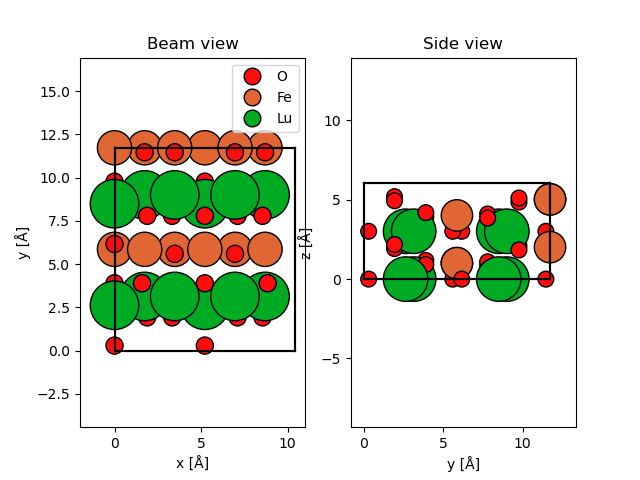

In [2]:
# atoms = ase.io.read("sto_lto.cif")

import sys
sys.path.append('../..')
lufeo3 = ase.io.read("../../data/structures/LFO_LS.vasp")
atoms = abtem.orthogonalize_cell(lufeo3)
atoms.rotate(-120, v=[1, 1, 1], rotate_cell=True)  # one call, same result
# anything smaller in magnitude becomes exactly 0 or atoms will be lost at z = 0
tol = 1e-6 
atoms.positions[np.abs(atoms.positions) < tol] = 0.0
atoms.cell[np.abs(atoms.cell) < tol] = 0.0

fig, (ax1, ax2) = plt.subplots(1, 2)
abtem.show_atoms(atoms, ax=ax1, plane="xy", title="Beam view", legend=True)
abtem.show_atoms(atoms, ax=ax2, plane="yz", title="Side view");

## Creating a `Potential` with the independent atom model <a id='potentials'></a>
We use the indepedent atom model (IAM) to create the electrostatic potential of the sample. In this standard approximation, the potential is a superposition of parameterized isolated atomic potentials. More information on potentials in *ab*TEM may be found in our [walkthrough](https://abtem.github.io/doc/user_guide/walkthrough/potentials.html).

To define a `Potential`, we need to provide an ASE `Atoms` object, a sampling rate (or pixel size) in $x$ and $y$, and a slice thickness in the $z$-direction (the propagation direction). 

The multislice algorithm is only accurate in the limit of good (small) sampling rate and thin slices, but improving these parameters also increases computational cost. A sensible value for the sampling is between $0.01 \ \mathrm{Å}$ and $\mathrm{0.05} \ \mathrm{Å}$ and the slice thickness is typically between $0.5 \ \mathrm{Å}$ and $2 \ \mathrm{Å}$.

In [3]:
potential = abtem.Potential(atoms, sampling=0.05, slice_thickness=2)

The potential has 33 slices along the $z$ propagation direction, as may be determined from getting its length.

In [4]:
len(potential)

4

The `.build` method is available for many *ab*TEM simulation objects. This method will convert them into a static array-based object.

In [5]:
potential_array = potential.build()

*ab*TEM is evaluated lazily using the Dask library, which means that the resulting array is not computed immediately - we have only created the instructions for computing the array. 

In [6]:
potential_array.array

dask.array<_wrap_build_potential, shape=(4, 209, 235), dtype=float32, chunksize=(4, 209, 235), chunktype=numpy.ndarray>

To actually calculate the array, we run the computation using the `.compute` method.

In [7]:
potential_array.compute()

[########################################] | 100% Completed | 756.42 ms


After computing, the built potential is described as a `NumPy` array.

In [8]:
potential_array.array

array([[[8.53561096e+01, 1.11430664e+02, 1.44625397e+02, ...,
         4.09937668e+01, 5.18833389e+01, 6.68463898e+01],
        [8.37583771e+01, 1.08135353e+02, 1.40033752e+02, ...,
         4.03507996e+01, 5.12094078e+01, 6.54813309e+01],
        [7.87388000e+01, 1.00008820e+02, 1.27008553e+02, ...,
         3.87380257e+01, 4.89696426e+01, 6.20434952e+01],
        ...,
        [7.13450623e+01, 8.89185410e+01, 1.09931183e+02, ...,
         3.63143044e+01, 4.55009003e+01, 5.70261726e+01],
        [7.87388077e+01, 1.00008827e+02, 1.27008553e+02, ...,
         3.87380180e+01, 4.89696388e+01, 6.20434952e+01],
        [8.37583847e+01, 1.08135353e+02, 1.40033722e+02, ...,
         4.03507957e+01, 5.12094078e+01, 6.54813232e+01]],

       [[1.67435950e+03, 9.89881714e+02, 6.08723572e+02, ...,
         5.26768372e+02, 7.86317444e+02, 1.33028210e+03],
        [1.05122534e+03, 8.06509277e+02, 5.65447327e+02, ...,
         4.92478546e+02, 6.85894104e+02, 9.46571350e+02],
        [6.46010254e+02, 

We can show the potential using the `.show` method - to display a 2D image, it is by default projected to the $xy$ plane.

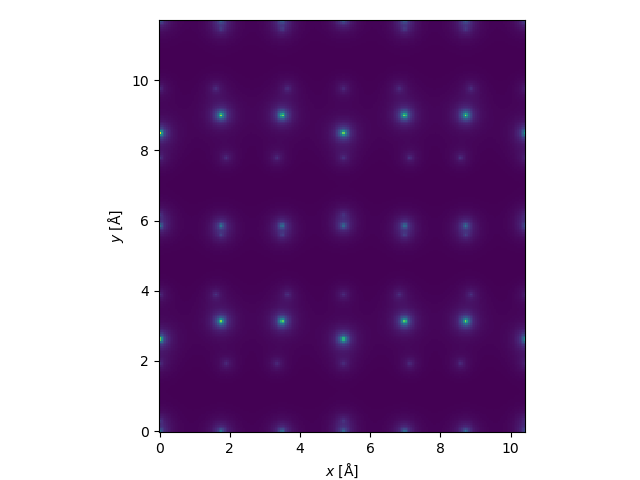

In [9]:
potential_array.show();

*ab*TEM has some features for showing the simulation objects interactively. Here, we convert the potential slice to a stack of images and show the result with `interact=True`, allowing us to scroll through slices. 

__Note__: This requires that the Matplotlib backend is using [`ipympl`](https://matplotlib.org/ipympl/).

In [10]:
potential_array.to_images().show(interact=True, cbar=True);

ImageGUI(children=(VBox(children=(SelectionSlider(description='z [Å]', options=('1.508', '3.015', '4.523', '6.…

## Creating `Probe` wave functions <a id='probes'></a>

The multislice algorithm works by propagating the $xy$ part a the wave function through the electrostatic potential along the $z$-axis. In STEM, the wave function is a focused beam of electrons. The convention used in *ab*TEM is a probe defined by

$$
    \phi(\mathbf{k}, \mathbf{r}_0) = A(k) \exp(-i \chi(\mathbf{k})) \exp(-i 2 \pi \mathbf{k} \cdot \mathbf{r}_p) \quad ,
$$

where $\mathbf{k} = (k_x, k_y)$ is the spatial frequency, $A(k)$ is the condenser aperture function and $\chi(\mathbf{k})$ is the phase error, and $\mathbf{r}_p = (x_p, y_p)$ is the probe position. (See our [walkthrough](https://abtem.github.io/doc/user_guide/walkthrough/contrast_transfer_function.html) on wave functions for more detail.)

If the microscope is well aligned, off-axis aberrations are small and the phase error is dominated by defocus and spherical aberration

$$
    \chi(k) \approx \frac{2\pi}{\lambda}\left( \frac{\lambda^2 k^2}{2} \Delta f + \frac{\lambda^4 k^4}{4} C_s \right) \quad ,
$$

where $\Delta f$ is the defocus and $C_s$ is the third order spherical aberration. (See our [walkthrough](https://abtem.github.io/doc/user_guide/walkthrough/contrast_transfer_function.html) on the contrast transfer function for more.)

We create a probe with an energy of $150 \ \mathrm{keV}$, a defocus of $50 \ \mathrm{Å}$, and a convergence semiangle of $20 \ \mathrm{mrad}$.

__Note__: Positive defocus is equivalent to backward free-space propagation, i.e. a probe with positive defocus is "in focus" inside the sample.

In [11]:
probe = abtem.Probe(energy=150e3, defocus=50, semiangle_cutoff=20)

We did not specify any grid for our probe, but we can simply match it to our potential.

In [12]:
probe.grid.match(potential)

We can `.build` the probe to obtain an (lazy) array representation, and then compute it.

In [13]:
probe_waves = probe.build()

probe_waves.array

dask.array<getitem, shape=(209, 235), dtype=complex64, chunksize=(209, 235), chunktype=numpy.ndarray>

In [14]:
probe_waves.compute()

[########################################] | 100% Completed | 213.51 ms


The wave function intensity can be shown in real or reciprocal space using the `.intensity` or `.diffraction_patterns` methods. 

__Note__: We used `grid.match`, hence the probe grid matches the potential. 

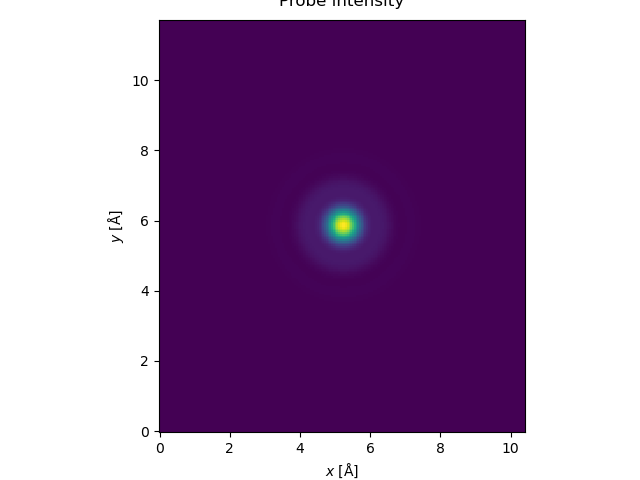

In [15]:
probe_waves.intensity().show(title="Probe intensity")

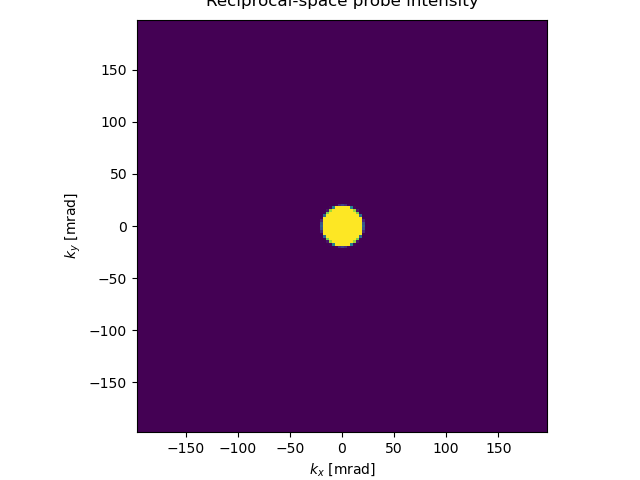

In [16]:
probe_waves.diffraction_patterns().show(
    title="Reciprocal-space probe intensity", units="mrad"
);

We can create probes with multiple different values of defocus (or other parameters) by providing a sequence of values, e.g. as a `NumPy` array. Here we create an ensemble of $5$ probes with a defocus ranging from $0$ to $200 \ \mathrm{Å}$.

In [17]:
focal_series = np.linspace(0, 200, 5)

focal_series_probe = abtem.Probe(
    energy=200e3, defocus=focal_series, semiangle_cutoff=20, extent=10, sampling=0.05
)

We make an interactive visualization to scroll through the probe ensemble. 

__Note__: The probe `extent` is too small to represent a probe with the largest defocus in the series. We are seeing errors due to probe self-interaction causing the probe to have only four-fold rotational symmetry as a consequence of the square probe window.

In [18]:
focal_series_probe.build().compute().show(interact=True);

[########################################] | 100% Completed | 206.34 ms


ImageGUI(children=(VBox(children=(SelectionSlider(description='C10 [Å]', options=('-0.000', '-50.000', '-100.0…

As an alternative to the interactive plots, we can set `explode=True` to show the entire ensemble.

[########################################] | 100% Completed | 106.35 ms


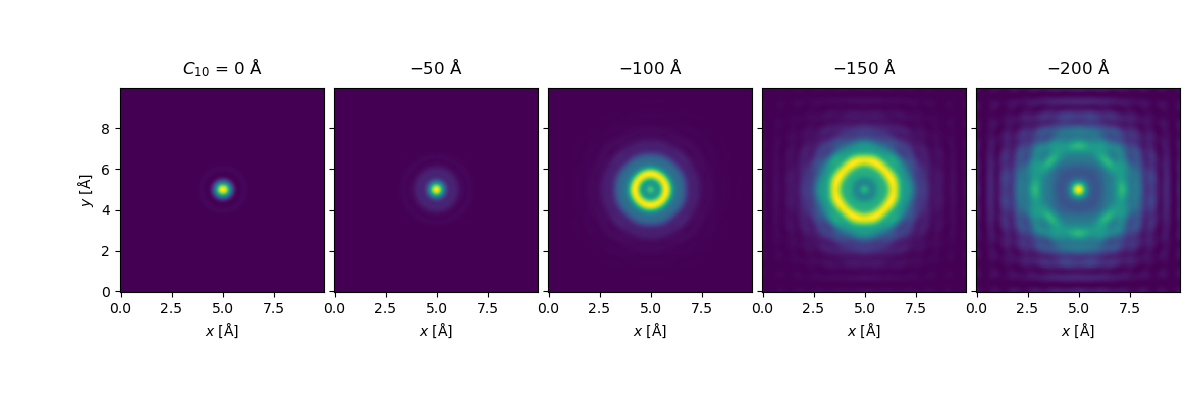

In [19]:
focal_series_probe.build().show(explode=True, figsize=(12, 4));

## Multislice simulation with a `Probe` (CBED) <a id='multislice'></a>
We use the multislice algorithm to propagate the probe through the potential. We can choose where to place the probe by setting the `scan` argument. Here we place the probe at $\mathbf{r}_p = (8,8) \ \mathrm{Å}$.

In [20]:
position = (8, 8)

exit_wave = probe.multislice(potential, scan=position)

We run `.compute` to calculate the exit wave.

In [21]:
exit_wave.compute()

[########################################] | 100% Completed | 114.77 ms


We can show the exit wave intensity.

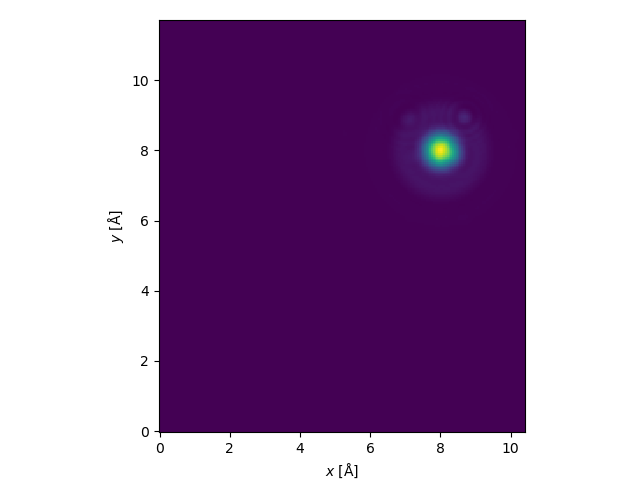

In [22]:
exit_wave_image = exit_wave.intensity()

exit_wave_image.show();

We can use an interactive visualization to show the diffraction on different power scales; reducing the power will reveal the weaker diffraction outside the bright-field disk.

In [23]:
exit_wave_diffraction = exit_wave.diffraction_patterns(max_angle="full")

exit_wave_diffraction.show(interact=True, cbar=True, units="mrad");

ImageGUI(children=(VBox(children=(HBox(children=(Button(description='Reset sliders', style=ButtonStyle()), Tog…

We set `max_angle="full"` above to show the diffraction pattern on the full simulation grid, but the maximum available simulated angle does not correspond to a full simulation grid. Instead, real-space sampling determines the maximum simulated scattering angle. 

The sampling defines the maximum spatial frequency $k_{max}$ via

$$ k_{max} = \frac{1}{2d} \quad , $$

where $d$ is the real-space sampling distance. To counteract aliasing artifacts due to the periodicity assumption of a discrete Fourier transform, *ab*TEM supresses spatial frequencies above 2 / 3 of the maximum scattering angle, further reducing the maximum effective scattering angle by that factor. Hence, the maximum scattering angle $\alpha_{max}$ is given by

$$ \alpha_{max} = \frac{2}{3}\frac{\lambda}{2p} \quad , $$

where $\lambda$ is the relativistic electron wavelength. 

## Scanned multislice simulation <a id='scan'></a>

Scanning imaging modes such as STEM works by rastering an electron probe across a sample pixel by pixel and recording the scattering signal. 

We create a grid scan and set the sampling (probe step size) to the Nyquist sampling of the probe. The resulting image can be interpolated to the typically much higher experimental sampling rate.

We only scan across $1 / 3$ of the potential along $x$ because it is repeated three times in this direction. This is most conviniently done using fractional coordinates, which then requires us to provide the potential as well.

In [24]:
scan = abtem.GridScan(
    start=(0, 0),
    end=(1 / 3, 1),
    sampling=probe.ctf.nyquist_sampling,
    fractional=True,
    potential=potential,
)

We can overlay the scan region over the atoms to confirm it matches what we desired.

/opt/miniconda3/envs/point_defects/lib/python3.11/site-packages/abtem/scan.py:1029: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle(


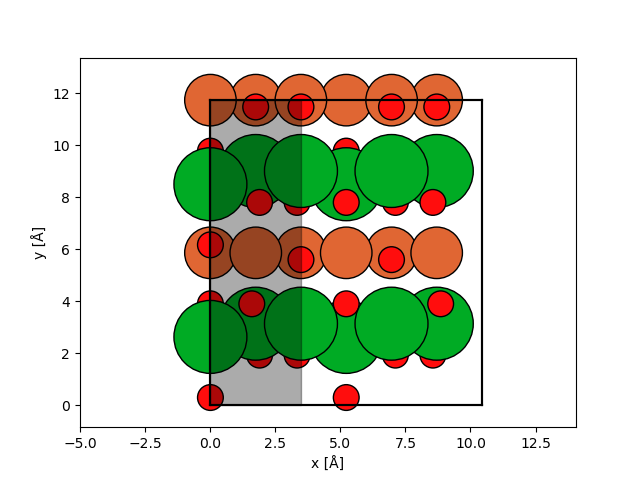

In [25]:
fig, ax = abtem.show_atoms(atoms)
scan.add_to_plot(ax, color="k");

__Note__: The scan `sampling` should not be confused with the wave function `sampling` due to discretization. The former is equivalent to the probe step size, while the second has no experimental equivalent.

In *ab*TEM the exit waves are "detected" using a detector object. There are several different types of detectors, and the most basic one, the `AnnularDetector`, may be used for bright-field, medium- or high-angle annular dark-field microscopy, depending on the angular integration range.

The integration region is given by an inner and an outer radius in mrad. Below, we create three different types of detectors.

In [26]:
bright = abtem.AnnularDetector(inner=0, outer=20)
maadf = abtem.AnnularDetector(inner=50, outer=120)
haadf = abtem.AnnularDetector(inner=100, outer=180)

detectors = [bright, maadf, haadf]

The outer radius can only be as large as the maximum simulated scattering angle.

In [27]:
print(f"alpha_max = {min(probe.cutoff_angles):.1f} mrad")

alpha_max = 195.4 mrad


The detector regions, given a wave function, may be retrieved using the get detector region method.

In [28]:
bright_region = bright.get_detector_region(probe)
maadf_region = maadf.get_detector_region(probe)
haadf_region = haadf.get_detector_region(probe)

To conveniently show all the regions together we stack them, providing a name for each, and show them with `explode=True`.

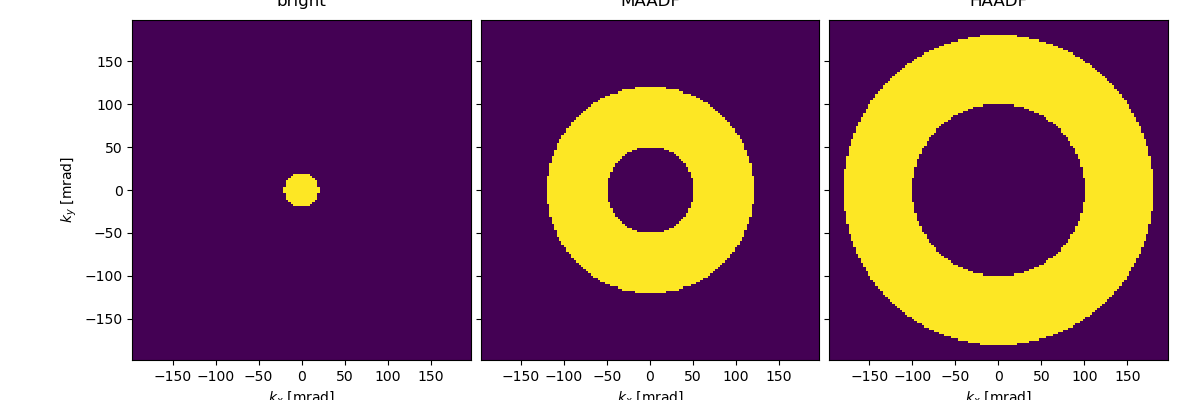

In [29]:
stacked_regions = abtem.stack(
    (bright_region, maadf_region, haadf_region), ("bright", "MAADF", "HAADF")
)

visualization = stacked_regions.show(explode=True, units="mrad", figsize=(12, 4))

The scanned multislice simulations are started as below, the simulation takes about 60s on my 2018 Macbook.

In [30]:
scanned_measurements = probe.scan(
    scan=scan,
    detectors=detectors,
    potential=potential,
)

scanned_measurements.compute()

[########################################] | 100% Completed | 2.41 sms


The output is given as a list of three `Images` objects, one for each detector. We can stack show the measurements with `explode=True`.

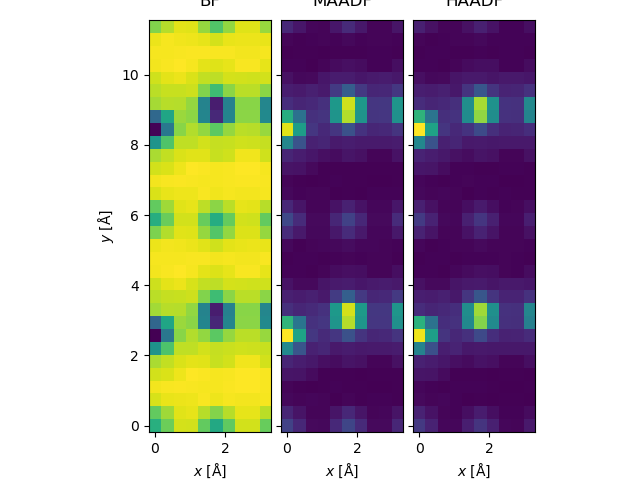

In [31]:
stacked_measurements = abtem.stack(scanned_measurements, ("BF", "MAADF", "HAADF"))

stacked_measurements.show(explode=True);

## Post-processing STEM measurements

STEM simulations usually requires some post-processing, so we apply the most common steps below.

### Interpolation

We saved a lot of computational time by scanning at the Nyquist frequency, but the result is quite pixelated. To address this, we interpolate the images to a sampling of $0.1 \ \mathrm{Å / pixel}$. *ab*TEM's default interpolation algorithm is Fourier-space padding (but spline interpolation is also available, which is more appropriate if the image in non-periodic).

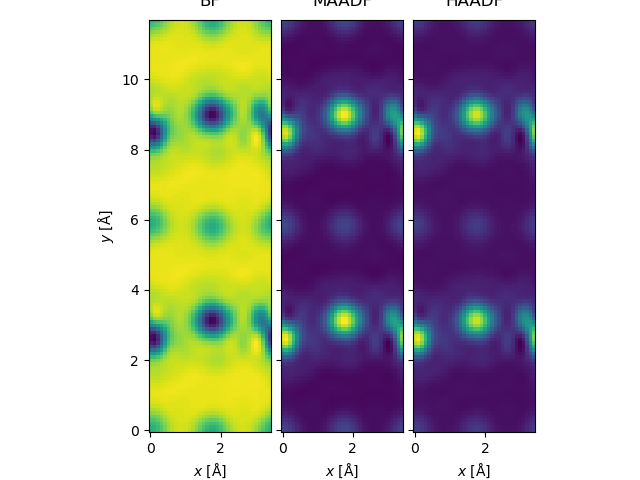

In [32]:
interpolated_measurements = stacked_measurements.interpolate(0.1)

interpolated_measurements.show(explode=True);

### Blurring

A finite Gaussian-shaped source will result in a blurring of the image. Vibrations and other instabilities may further contribute to the blur. We apply a Gaussian blur with a standard deviation of $0.5 \ \mathrm{Å}$ (corresponding to a source of approximately that size).

__Note__: We are not including partial temporal incoherence here. See our [tutorial on partial coherence](../tutorials/partial_coherence.ipynb).

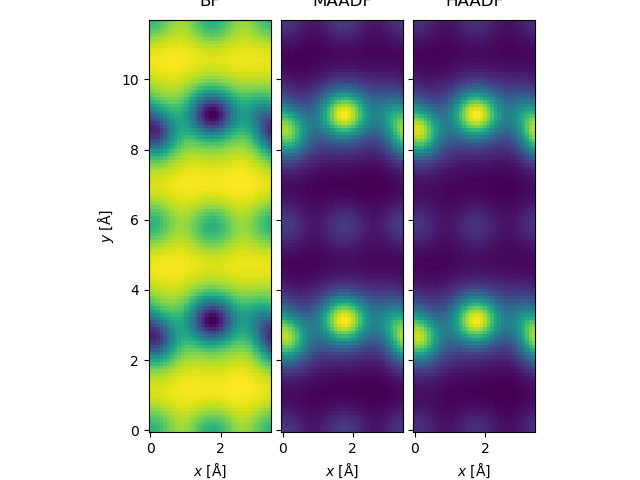

In [33]:
blurred_measurements = interpolated_measurements.gaussian_filter(0.35)

blurred_measurements.show(explode=True);

### Noise

Simulations such as the above corresponds to the limit of infinite electron dose. We can emulate finite dose by drawing random numbers from a Poisson distribution for every pixel.

Before applying the noise, we tile the images to get better statistics.

In [34]:
tiled_measurements = blurred_measurements.tile((8, 3))

We apply Poisson noise corresponding a dose per area of $10^4 \ \mathrm{e}^- / \mathrm{Å}^2$.

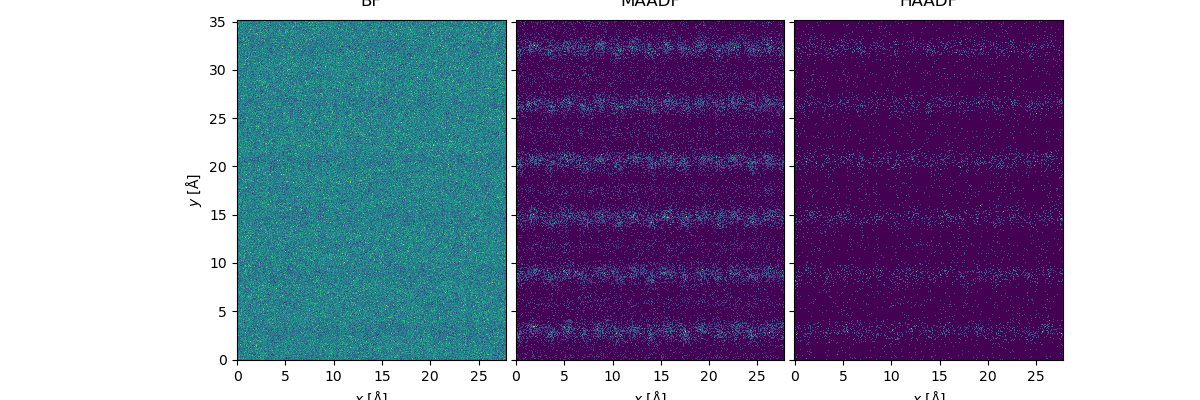

In [35]:
noisy_measurements = tiled_measurements.poisson_noise(dose_per_area=1e4, seed=100)

noisy_measurements.show(explode=True, figsize=(12, 4));

## HRTEM simulations with `PlaneWaves` <a id='hrtem'></a>

Running an HRTEM simulation is not very different from doing a CBED simulation. Instead of creating a `Probe`, we now create a `PlaneWave` with an energy of $150 \ \mathrm{keV}$.

In [36]:
plane_wave = abtem.PlaneWave(energy=150e3)

We will show an example of how to simulate a thickness series. To do this, we have to recreate our potential with the `exit_planes` argument. We set it to one to specify that we want an output exit wave for every single slice.

In [37]:
potential = abtem.Potential(atoms, sampling=0.05, slice_thickness=2, exit_planes=1)

__Note__: We did not define the wave function sampling, hence it will match the potential. We do not need to match the sampling of the wavefunction to an experimental pixel size, as we can always interpolate the final result.

We run the mulislice algorithm. 

In [38]:
exit_wave = plane_wave.multislice(potential).compute()

[########################################] | 100% Completed | 105.67 ms


We show the exit wave intensity - note that the first slices do not contain atoms and thus the exit waves simply show numerical noise.

In [39]:
exit_wave.show(interact=True);

ImageGUI(children=(VBox(children=(SelectionSlider(description='z [Å]', options=('0.000', '1.508', '3.015', '4.…

We now have to specify the aberrations and aperture of the objective lens. 

We create a compatible `CTF` for electrons of the same energy as the plane wave of $150 \ \mathrm{keV}$. The spherical aberration will be set to $-20~\mu \mathrm{m}$ (remember that *ab*TEM uses units of $\mathrm{Å}$) and the defocus is set to the [Scherzer defocus](https://en.wikipedia.org/wiki/High-resolution_transmission_electron_microscopy).

In [40]:
Cs = -20e-6 * 1e10
ctf = abtem.CTF(Cs=Cs, energy=150e3)

ctf.scherzer_defocus

-94.18663310108816

In [41]:
ctf.defocus = ctf.scherzer_defocus

We can show a radial profile of the `CTF`.

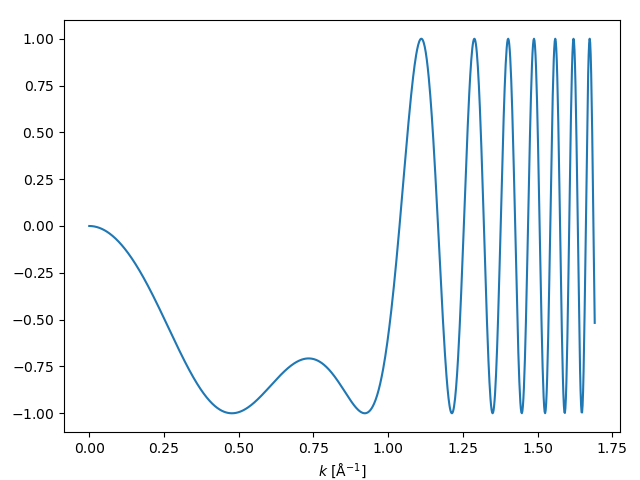

In [42]:
ctf.profiles().show();

The angle transferred to the detector plane is limited by the aperture of the objective lens. This is described as a multiplication with the aberrations and the aperture function $A(k)$:

$$
    \psi_{\mathrm{image}}(k, \phi) = A(k) \exp[-i \chi(k, \phi)] \psi_{\mathrm{exit}}(k, \phi) \quad.
$$

The aperture is modelled by cutting off the `CTF` at the angle corresponding to the Scherzer [point resolution](https://en.wikipedia.org/wiki/High-resolution_transmission_electron_microscopy#Scherzer_defocus), which is defined as the angle where the phase of the `CTF` crosses the abscissa for the first time (`crossover_angle`).

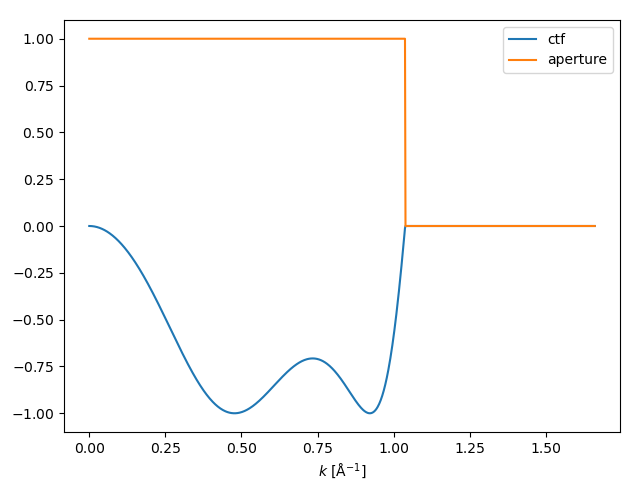

In [43]:
ctf.semiangle_cutoff = ctf.crossover_angle

ctf.profiles().show(legend=True);

We apply the `CTF` to the exit wave to get the wave at the detector plane.

In [44]:
image = exit_wave.apply_ctf(ctf).intensity()

In [45]:
image.show(interact=True);

ImageGUI(children=(VBox(children=(SelectionSlider(description='z [Å]', options=('0.000', '1.508', '3.015', '4.…

We can tile the result and apply Poisson noise; we now see that the numerical artifacts in the first slices are no longer visible at a finite dose.

In [46]:
noisy_image = image.tile((2, 2)).poisson_noise(1e4)

noisy_image.show(title="HRTEM image", interact=True);

ImageGUI(children=(VBox(children=(SelectionSlider(description='z [Å]', options=('0.000', '1.508', '3.015', '4.…